### Carga de los datos

In [3]:
import numpy as np
import pandas as pd

# Establecer la semilla aleatoria para NumPy, TensorFlow, el generador de números aleatorios de Python
# y para la función de hash interna de Python
import tensorflow as tf
import random
import os
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
# Reducir el uso de múltiples núcleos para evitar variabilidad
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

print(data_train.head())
print(data_test.head())

data_train=np.array(data_train)
data_test=np.array(data_test)

     Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
518     0.395349            0.246374        0.331337       0.111447   
601     0.395349            0.198473        0.273396       0.490744   
602     0.139535            0.167176        0.252471       0.490744   
968     0.418605            0.317557        0.151627       0.576502   
325     0.651163            0.231298        0.182481       0.492255   

     Habitantes  
518      0.5625  
601      0.2500  
602      0.2500  
968      0.5625  
325      0.3750  
      Temperatura  Consumo_Lavanderia  Consumo_Cocina  Resto_Consumo  \
847      0.604651            0.203817        0.187748       0.219500   
298      0.232558            0.360687        0.181398       0.105780   
197      0.418605            0.243321        0.338336       0.170759   
1065     0.441860            0.244656        0.129014       0.223649   
881      0.697674            0.298664        0.159391       0.408765   

      Habitantes  
847       0.4

### Entrenamiento del modelo

In [4]:
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

tf.random.set_seed(42)

# Crear el modelo autoencoder con inicialización reproducible
input_dim = data_train.shape[1]
encoding_dim = 9 #8  # Dimensión de la capa oculta 
input_layer = Input(shape=(input_dim,))
encoder_layer = Dense(encoding_dim, activation='relu', kernel_initializer=GlorotUniform(seed=42))(input_layer)
decoder_layer = Dense(input_dim, activation='sigmoid', kernel_initializer=GlorotUniform(seed=42))(encoder_layer)

autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Entrenar el autoencoder
history = autoencoder.fit(data_train, data_train, epochs=85, batch_size=32, 
                          shuffle=False, validation_split=0.1, verbose=0)

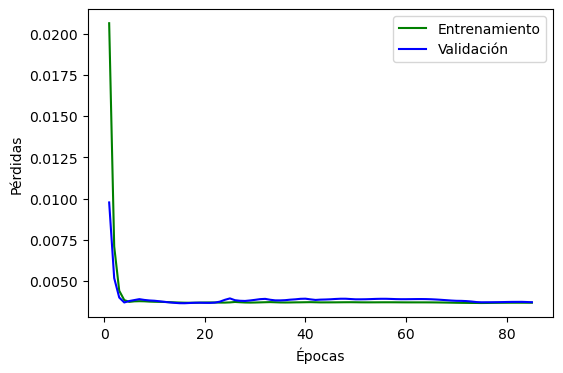

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


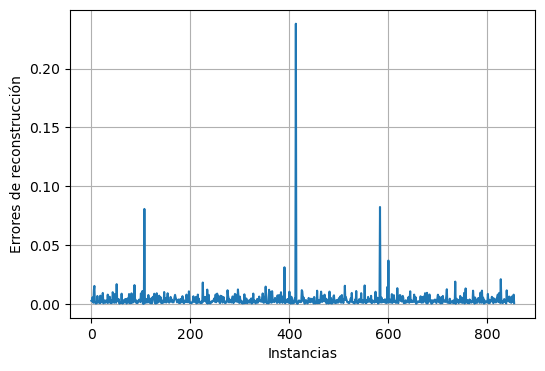

In [5]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Crear la gráfica
plt.figure(figsize=(6, 4))
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Entrenamiento')
plt.plot(epochs, val_loss, 'b', label='Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdidas')
plt.legend()
plt.show()

# Cálculo de los errores de reconstrucción
train_preds = autoencoder.predict(data_train)

# Evaluar el autoencoder en el conjunto de train
mse_train_errors = np.mean(np.power(data_train - train_preds, 2), axis=1)

plt.figure(figsize=(6, 4))
plt.grid(True)
plt.plot(mse_train_errors)
plt.xlabel('Instancias')
plt.ylabel('Errores de reconstrucción')
plt.show()

### Análisis de TDA, TFA, Precisión y Umbral

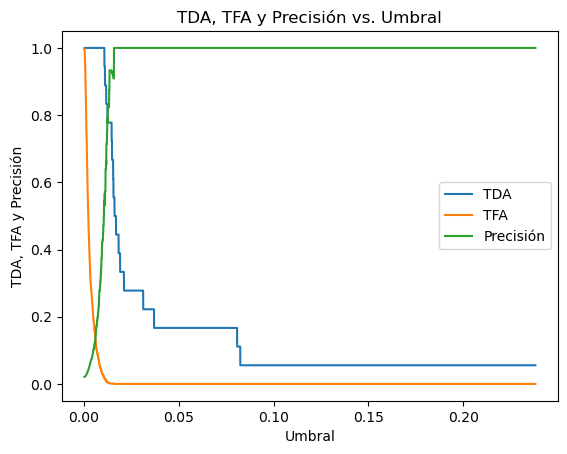

In [6]:
from sklearn.metrics import confusion_matrix

umbral = np.arange(np.min(mse_train_errors), np.max(mse_train_errors), 0.00001)
tda=[]
tfa=[]
precis=[]

for i in range(len(umbral)):
    predicciones = np.where(mse_train_errors > umbral[i], 1, 0)
    cm = confusion_matrix(etiq_verd_train, predicciones) 
    VP = cm[1, 1]
    FP = cm[0, 1]
    VN = cm[0, 0]
    FN = cm[1, 0]
    TDA= VP/(VP+FN) # Describe a la clase positiva (Clase Pos=VP+FN;Clase Neg=VN+FP)
    TFA=FP/(VN+FP)
    PREC=VP/(VP+FP) # Describe a las predicciones positivas correctas (PrediccPosit=VP+FP)
    tda.append(TDA)
    tfa.append(TFA)
    precis.append(PREC)

plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
plt.show()

### Selección manual de valores de TDA y TFA

(min TFA)/TDA=1: 0.0179


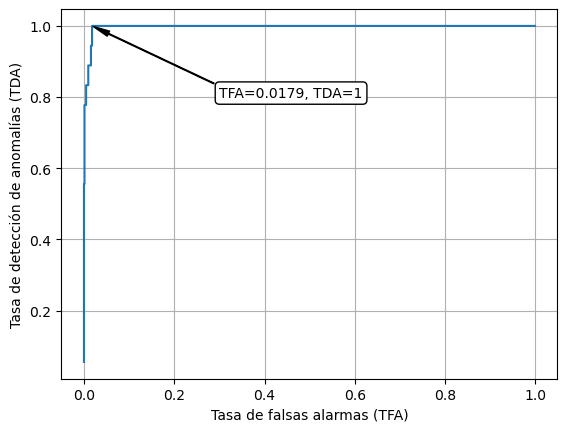

In [7]:
# Encontrar el menor valor de TFA cuando TDA es igual a 1
min_tfa = min([tfa[j] for j in range(len(tda)) if tda[j] == 1], default=np.nan)
print(f'(min TFA)/TDA=1: {min_tfa:.4f}')

plt.plot(tfa, tda)  
plt.xlabel('Tasa de falsas alarmas (TFA)')
plt.ylabel('Tasa de detección de anomalías (TDA)')
plt.grid(True)

# Agregar una etiqueta en (0.3, 0.8)
plt.annotate(f'TFA={min_tfa:.4f}, TDA=1', xy=(min_tfa, 1), xytext=(0.3, 0.8),
             arrowprops=dict(facecolor='black', shrink=0.01, width=0.5, headwidth=4),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))
plt.show()

### Cálculo del umbral, y resultados del entrenamiento (data_train)

In [8]:
from sklearn.metrics import classification_report

valor_tfa=min_tfa
valor_tda=1

def encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda):
    distancias = []
    for i in range(len(tfa)):
        distancia = np.sqrt((tfa[i] - valor_tfa)**2 + (tda[i] - valor_tda)**2)
        distancias.append(distancia)
    indice_minimo = np.argmin(distancias)
    return indice_minimo

index_umb=encontrar_indice_mas_cercano(tfa, tda, valor_tfa, valor_tda)
umbral_dec=umbral[index_umb]
print ("Umbral para la decisión:", umbral_dec)
print("-----------------------------------------------------------------------")

anomalias = data_train[mse_train_errors > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(mse_train_errors > umbral_dec, 1, 0)
print(classification_report(etiq_verd_train, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Umbral para la decisión: 0.01081970463369908
-----------------------------------------------------------------------
Número de anomalías detectadas: 33
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       837
           1       0.55      1.00      0.71        18

    accuracy                           0.98       855
   macro avg       0.77      0.99      0.85       855
weighted avg       0.99      0.98      0.98       855

------------------------------------------------------------------------
[[822  15]
 [  0  18]]
VP: 18
FP: 15
VN: 822
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.017921146953405017
Precision: 0.5454545454545454
F1: 0.7058823529411764


### Análisis y resultados en la validación (data_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step


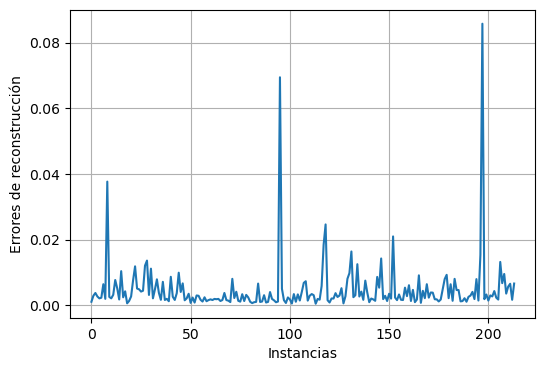

Número de anomalías detectadas: 15
------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       204
           1       0.67      1.00      0.80        10

    accuracy                           0.98       214
   macro avg       0.83      0.99      0.89       214
weighted avg       0.98      0.98      0.98       214

------------------------------------------------------------------------
[[199   5]
 [  0  10]]
VP: 10
FP: 5
VN: 199
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.024509803921568627
Precision: 0.6666666666666666
F1: 0.8


In [9]:
# Calcula los errores de reconstrucción
test_preds = autoencoder.predict(data_test)

# Evaluar el autoencoder en el conjunto de prueba
mse_test_errors = np.mean(np.power(data_test - test_preds, 2), axis=1)

plt.figure(figsize=(6, 4))
plt.grid(True)
plt.plot(mse_test_errors)
plt.xlabel('Instancias')
plt.ylabel('Errores de reconstrucción')
plt.show()

anomalias = data_test[mse_test_errors > umbral_dec]
print("Número de anomalías detectadas:", len(anomalias))
print("------------------------------------------------------------------------")

etiq_pred = np.where(mse_test_errors > umbral_dec, 1, 0)
print(classification_report(etiq_verd_test, etiq_pred))
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

#### Graficar el umbral

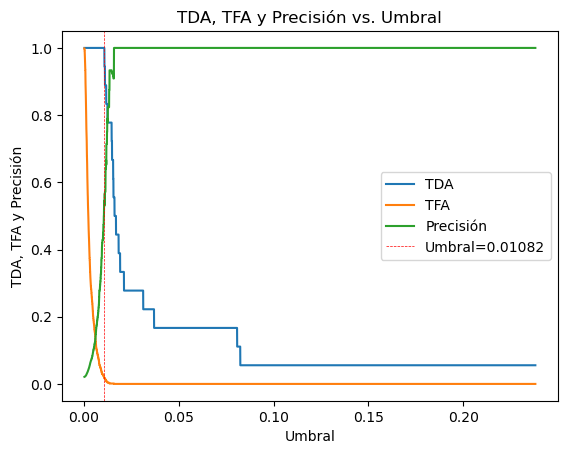

In [10]:
plt.plot(umbral, tda, label='TDA')
plt.plot(umbral, tfa, label='TFA')
plt.plot(umbral,precis,label='Precisión')
plt.xlabel('Umbral')  
plt.ylabel('TDA, TFA y Precisión') 
plt.title('TDA, TFA y Precisión vs. Umbral')
plt.legend()
# Agregar líneas verticales discontinuas
plt.axvline(x=umbral_dec, color='r', linestyle='--', linewidth=0.5, label=f'Umbral={umbral_dec:.5f}')
plt.legend()
plt.show()

### Ajuste fino del umbral
#### Umbral definitivo Umbral=0.00865

In [90]:
umbral_fino = input("Valor del umbral:")
umbral_fino=float(umbral_fino)

print(" \n  \n ---------------- Datos de entrenamiento ----------------------------- \n ")
anomalias = data_train[mse_train_errors > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))

etiq_pred = np.where(mse_train_errors > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_train, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("F1:", F1)

print(" \n  \n ---------------- Datos de validación --------------------------- \n ")
anomalias = data_test[mse_test_errors > umbral_fino]
print("Número de anomalías detectadas:", len(anomalias))


etiq_pred = np.where(mse_test_errors > umbral_fino, 1, 0)
print("------------------------------------------------------------------------")

cm = confusion_matrix(etiq_verd_test, etiq_pred)
print(cm)
VP = cm[1, 1]
FP = cm[0, 1]
VN = cm[0, 0]
FN = cm[1, 0]
print("VP:",VP)
print("FP:",FP)
print("VN:",VN)
print("FN:",FN)
print("------------------------------------------------------------------------")

TDA= VP/(VP+FN)
TFA=FP/(VN+FP)
Precision=VP/(VP+FP)
especificidad=VN/(VN+FP)
F1 = 2 * (Precision * TDA) / (Precision + TDA)

print("TDA:", TDA)
print("TFA:", TFA)
print("Precision:", Precision)
print("Especificidad",especificidad)
print("F1:", F1)

Valor del umbral:0.01083
 
  
 ---------------- Datos de entrenamiento ----------------------------- 
 
Número de anomalías detectadas: 32
------------------------------------------------------------------------
[[822  15]
 [  1  17]]
VP: 17
FP: 15
VN: 822
FN: 1
------------------------------------------------------------------------
TDA: 0.9444444444444444
TFA: 0.017921146953405017
Precision: 0.53125
F1: 0.6799999999999999
 
  
 ---------------- Datos de validación --------------------------- 
 
Número de anomalías detectadas: 15
------------------------------------------------------------------------
[[199   5]
 [  0  10]]
VP: 10
FP: 5
VN: 199
FN: 0
------------------------------------------------------------------------
TDA: 1.0
TFA: 0.024509803921568627
Precision: 0.6666666666666666
F1: 0.8


# Ajuste de hiperparámetros de la red autoencoder
#### Se fueron variando los valores de LR y de neuronas de la capa oculta. LR=0.001 en el método de Adam. Al añadir regularización (Dropout), no se obtienen buenos resultados

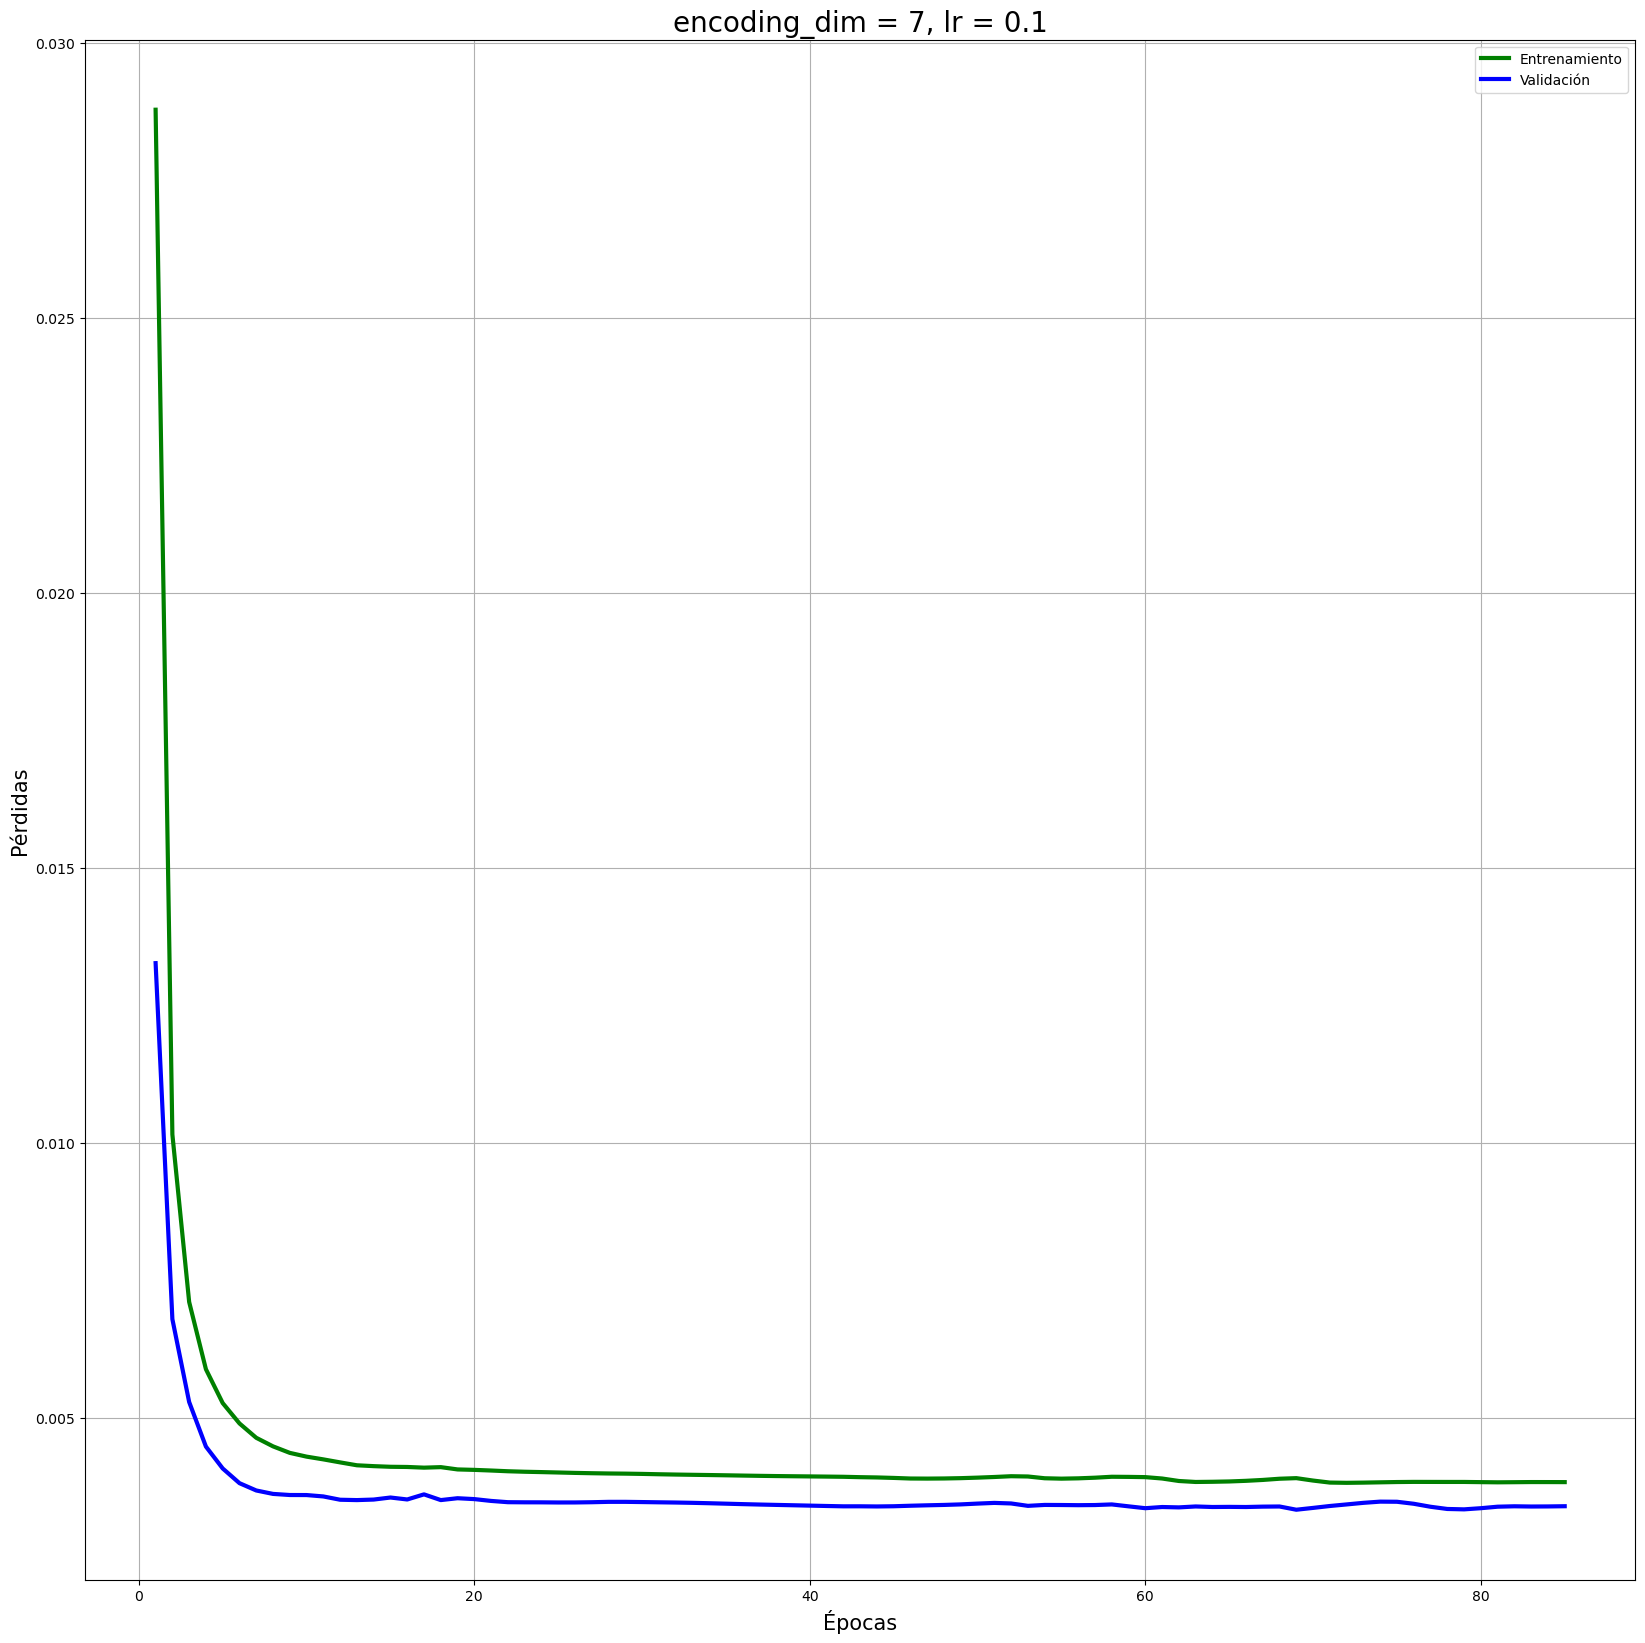

<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
import pandas as pd
#from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.initializers import GlorotUniform
import matplotlib.pyplot as plt

# Establecer la semilla aleatoria para NumPy, TensorFlow, el generador de números aleatorios de Python
# y para la función de hash interna de Python
import tensorflow as tf
import random
import os
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
# Reducir el uso de múltiples núcleos para evitar variabilidad
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

# Cargar los datos
X_test = pd.read_excel('Datos_test.xlsx', index_col=0)
X_train = pd.read_excel('Datos_train.xlsx', index_col=0)

# Crea el modelo autoencoder
input_dim = X_train.shape[1]

# Valores de encoding_dim, learning_rate y regularización a ensayar
encoding_dims = [7]
learning_rates = [0.1]

# Crear subplots
fig, axes = plt.subplots(len(encoding_dims), len(learning_rates), figsize=(20, 20))

# Asegurarse de que axes sea un array 2D incluso si tiene solo una fila o columna
if len(encoding_dims) == 1 and len(learning_rates) == 1:
    axes = np.array([[axes]])
elif len(encoding_dims) == 1:
    axes = np.array([axes])
elif len(learning_rates) == 1:
    axes = np.array([[ax] for ax in axes])

for i, encoding_dim in enumerate(encoding_dims):
    for j, lr in enumerate(learning_rates):
        # Definir capas del autoencoder
        input_layer = Input(shape=(input_dim,)) 
        encoder_layer = Dense(encoding_dim, activation='relu', 
                              kernel_initializer=GlorotUniform(seed=42))(input_layer)
        #encoder_layer = Dropout(valor_dropout)(encoder_layer)
        decoder_layer = Dense(input_dim, activation='sigmoid', 
                      kernel_initializer=GlorotUniform(seed=42))(encoder_layer)
        
        # Crear y compilar el modelo
        autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
        autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        
        # Entrenar el autoencoder
        history = autoencoder.fit(X_train, X_train, epochs=85, 
                                  batch_size=32, shuffle=False, validation_split=0.1, verbose=0)
        
        # Obtener pérdidas de entrenamiento y validación
        train_loss = history.history['loss']
        val_loss = history.history['val_loss']
        
        # Crear la gráfica en el subplot correspondiente
        epochs = range(1, len(train_loss) + 1)
        ax = axes[i, j]
        ax.plot(epochs, train_loss, 'g', label='Entrenamiento', linewidth=3)
        ax.plot(epochs, val_loss, 'b', label='Validación', linewidth=3)
        ax.set_title(f'encoding_dim = {encoding_dim}, lr = {lr}', fontsize=20)
        ax.set_xlabel('Épocas', fontsize=15)
        ax.set_ylabel('Pérdidas', fontsize=15)
        ax.legend()
        ax.grid(True)

# Ajustar el layout
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()
plt.tight_layout()
plt.show()

## Análisis de TFA cuando TDA=1, para diferentes valores de hiperparámetros

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
from keras.initializers import GlorotUniform
import matplotlib.pyplot as plt

# Establecer la semilla aleatoria para NumPy, TensorFlow, el generador de números aleatorios de Python
# y para la función de hash interna de Python
import tensorflow as tf
import random
import os
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
# Reducir el uso de múltiples núcleos para evitar variabilidad
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['OMP_NUM_THREADS'] = '1'
os.environ['TF_NUM_INTRAOP_THREADS'] = '1'
os.environ['TF_NUM_INTEROP_THREADS'] = '1'

data_train=pd.read_excel('Datos_train.xlsx',index_col=0)
data_test = pd.read_excel('Datos_test.xlsx',index_col=0)  
etiq_verd_train=data_train[['Etiq']]
etiq_verd_test=data_test[['Etiq']]
data_train = data_train[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]
data_test = data_test[['Temperatura','Consumo_Lavanderia', 'Consumo_Cocina', 
                         'Resto_Consumo', 'Habitantes']]

data_train=np.array(data_train)
data_test=np.array(data_test)

# Crear el modelo autoencoder
input_dim = data_train.shape[1]

# Valores de encoding_dim, learning_rate y regularización a ensayar
encoding_dims = [7,8,9,10]
learning_rates = [0.1,0.01]

min_tfa_values = []

for encoding_dim in encoding_dims:
    for lr in learning_rates:
        # Definir capas del autoencoder
        input_layer = Input(shape=(input_dim,))
        encoder_layer = Dense(encoding_dim, activation='relu', 
                              kernel_initializer=GlorotUniform(seed=42))(input_layer)
        decoder_layer = Dense(input_dim, activation='sigmoid', 
                              kernel_initializer=GlorotUniform(seed=42))(encoder_layer)
        
        # Crear y compilar el modelo
        autoencoder = Model(inputs=input_layer, outputs=decoder_layer)
        autoencoder.compile(optimizer=Adam(learning_rate=lr), loss='mean_squared_error')
        
        # Entrenar el autoencoder
        autoencoder.fit(data_train, data_train, epochs=85, batch_size=32, 
                        shuffle=False, validation_split=0.1, verbose=0)
        
        # Cálculo de los errores de reconstrucción
        train_preds = autoencoder.predict(data_train)

        # Evaluar el autoencoder en el conjunto de train
        mse_error = np.mean(np.power(data_train - train_preds, 2), axis=1)
        
        # Definir el rango de umbrales
        umbral = np.arange(np.min(mse_error), np.max(mse_error), 0.00001)
        tda = []
        tfa = []
        
        for i in range(len(umbral)):
            # Predicciones basadas en el umbral
            predicciones = np.where(mse_error > umbral[i], 1, 0)
            cm = confusion_matrix(etiq_verd_train, predicciones)
            VP = cm[1, 1]
            FP = cm[0, 1]
            VN = cm[0, 0]
            FN = cm[1, 0]
            TDA = VP / (VP + FN)
            TFA = FP / (VN + FP)
            tda.append(TDA)
            tfa.append(TFA)
        
        # Encontrar el menor valor de TFA cuando TDA es igual a 1
        min_tfa = min([tfa[j] for j in range(len(tda)) if tda[j] == 1], default=np.nan)
        min_tfa_values.append((encoding_dim, lr, min_tfa))
        print(f'encoding_dim: {encoding_dim}, learning_rate: {lr}, TFA/TDA=1: {min_tfa:.4f}')

# Mostrar los resultados
for encoding_dim, lr, min_tfa in min_tfa_values:
    print(f'encoding_dim: {encoding_dim}, learning_rate: {lr}, TFA/TDA=1: {min_tfa:.4f}')

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 7, learning_rate: 0.1, TFA/TDA=1: 0.1135
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 7, learning_rate: 0.01, TFA/TDA=1: 0.1075
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 8, learning_rate: 0.1, TFA/TDA=1: 0.2449
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 8, learning_rate: 0.01, TFA/TDA=1: 0.0239
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 9, learning_rate: 0.1, TFA/TDA=1: 0.0179
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 9, learning_rate: 0.01, TFA/TDA=1: 0.3106
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 10, learning_rate: 0.1, TFA/TDA=1: 0.1039
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
encoding_dim: 10, learning_rate: 0.01, TFA/TDA=1: 0.7814
encoding_dim: 7, learning_rate: 0.1, TFA/TDA=1: 0.1135
encoding_dim: 7, learning_rate: 0.01, TFA/TDA=1: 0.1075
encoding_dim: 8, learning_rate: 0.1, TFA/TDA=1: 0.2449
encoding_dim: 8, learning_rate: 0.01, TFA/TDA=1: 0.0239
encoding_dim: 9, lea

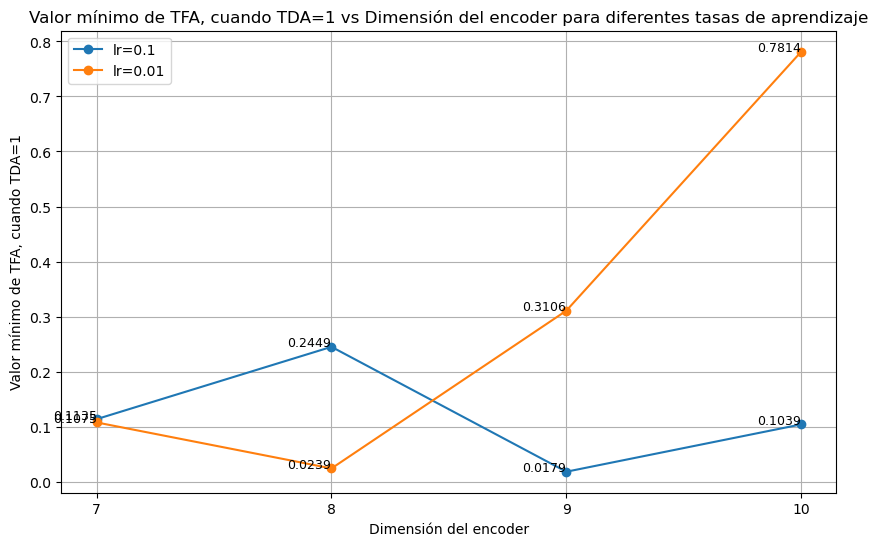

In [5]:
import matplotlib.pyplot as plt
# Crear un diccionario para almacenar los resultados por learning_rate
results = {}
for encoding_dim, lr, min_tfa in min_tfa_values:
    if lr not in results:
        results[lr] = {'encoding_dim': [], 'min_tfa': []}
    results[lr]['encoding_dim'].append(encoding_dim)
    results[lr]['min_tfa'].append(min_tfa)

# Crear el gráfico
plt.figure(figsize=(10, 6))

for lr, data in results.items():
    plt.plot(data['encoding_dim'], data['min_tfa'], marker='o', label=f'lr={lr}')
    for x, y in zip(data['encoding_dim'], data['min_tfa']):
        plt.text(x, y, f'{y:.4f}', fontsize=9, ha='right')

plt.xlabel('Dimensión del encoder')
plt.ylabel('Valor mínimo de TFA, cuando TDA=1')
plt.title('Valor mínimo de TFA, cuando TDA=1 vs Dimensión del encoder para diferentes tasas de aprendizaje')
plt.legend()
plt.grid(True)

# Asegurarse de que el eje X solo tenga números enteros
plt.xticks(range(min(min_tfa_values, key=lambda x: x[0])[0], max(min_tfa_values, key=lambda x: x[0])[0] + 1))

plt.show()